In [1]:
"""
Basic Vocab

# Observations/Instances/Samples:
- In machine learning, an observation refers to a single instance of data in a dataset.
- Each observation consists of several features and, in supervised learning, a target label.
- A sample is a subset of observations/instances in a data set.
From: https://deepchecks.com/glossary/observation-ml/

# Target Label/Variable/Class
- A target is a dataset variable to be predicted by an ML model.
  This is the variable that describes the outcome of the process.
  Broadly speaking, the terms label, class, and target may be used interchangeably.
From https://toloka.ai/blog/machine-learning-labels-and-features/

# Supervised vs Unsupervised Learning:
This notebook is an exercise in supervised learning to finetune a pre-trained large language model (LLM)
using samples labeled for gender bias for sentiment analysis.
Further reading: 
- https://www.ibm.com/think/topics/supervised-vs-unsupervised-learning
- https://blogs.nvidia.com/blog/what-is-a-transformer-model/
- https://www.datacamp.com/blog/attention-mechanism-in-llms-intuition

# Paper discussing types of gender bias in language
- https://arxiv.org/pdf/2201.08675
- https://arxiv.org/pdf/2111.03612

Datasets originate from:
- locally deployed LLama 3 LLM (~554)
- https://www.kaggle.com/datasets/dgrosz/sexist-workplace-statements (1138)

DistilBERT Refs
- https://huggingface.co/docs/transformers/tasks/sequence_classification
"""
print()

In [2]:
# Import Hugging Face datasets lib
from datasets import load_from_disk, DatasetDict

"""
Open 'aggregate_data.tsv' to inspect the data set.
The columns should be self-explanatory, with the exception of 'label':
- 0 indicates a lack of societal gender bias.
- 1 indicates a presence of societal gender bias.
"""
dataset = load_from_disk("./dataset_revised")

In [3]:
# Inspect individual example.
dataset[0]

{'id': 1,
 'sentence': "Gender diversity in parenting styles enriches children's upbringing.",
 'label': 0}

In [4]:
# Optional: Add data to the dataset.

# To add an item(s):
# Define an additional item. You can do this by adding an itemB, itemC, etc.
itemA = {'id': 1,
 'sentence': "Some sentence here.",
 'label': 0}

# Add it to the dataset. Uncomment the below line to add the sentence.
# You can add_item on additional items (e.g. itemB) if created above.
# dataset = dataset.add_item(itemA)

# Print the last dataset entry (which would have just been added)
dataset[-1]

{'id': 1690,
 'sentence': 'Questioning is important for breakthrough innovation that in future companies will have a CXO level Position that leads all the interesting innovation - CQO Chief Questioning Officer.',
 'label': 0}

In [5]:
"""
PRE-PROCESSING (https://arxiv.org/pdf/2111.03612, pg. 3)
- Hyphens and hashtags swap for whitespace
- Swap all usernames with string 'username'
- Lowercase it all
- Purge punctuation

Note that removing typical NLP stop words would likely trash our accuracy,
given the context stop words contain.
"""
import re
import string

def preprocess_text(text):
    # Replace hyphens with whitespace
    text = text.replace('-', ' ')
    
    # Remove all '#' symbols
    text = text.replace('#', '')
    
    # Replace Twitter usernames (e.g., @username) with the word "username"
    text = re.sub(r'@\w+', 'username', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercase all words
    text = text.lower()
    
    return text

def preprocess_dataset(dataset):
    def preprocess_example(example):
        example['sentence'] = preprocess_text(example['sentence'])
        return example
    
    return dataset.map(preprocess_example)

#dataset = dataset.remove_columns(['id'])
dataset = preprocess_dataset(dataset)


In [6]:
# Inspect pre-processed example.
dataset[0]

{'id': 1,
 'sentence': 'gender diversity in parenting styles enriches childrens upbringing',
 'label': 0}

In [7]:
# Tokenize dataset. Do not modify this block.

from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=False)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Load accuracy metric. Do not modify this block.
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [9]:
# Label mappings. Do not modify this block.
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

"""
Load DistilBERT with AutoModelForSequenceClassification along with the number of expected labels,
and the label mappings
"""
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Split dataset into train and test.
def split_dataset(dataset, test_size=0.2, seed=42):
    """
    Split the Hugging Face dataset into training and test sets.

    Parameters:
    - dataset: Hugging Face dataset obj
    - test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
    - seed (int): Random seed for reproducibility (default is 42).

    Returns:
    - DatasetDict: A dictionary with 'train' and 'test' splits.
    """

    # Split the dataset into training and test sets
    train_test_split = dataset.train_test_split(test_size=test_size, seed=seed)
    
    # Return the DatasetDict with 'train' and 'test' splits
    return DatasetDict({
        'train': train_test_split['train'],
        'test': train_test_split['test']
    })

# Split the dataset
dataset_splits = split_dataset(tokenized_dataset)

In [12]:
training_args = TrainingArguments(
    output_dir="model_output_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_splits["train"],
    eval_dataset=dataset_splits["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196773,0.937870
2,No log,0.180725,0.937870


In [13]:
"""
Inference Time
https://huggingface.co/docs/transformers/en/pipeline_tutorial
"""
from transformers import DistilBertForSequenceClassification
from transformers import pipeline

loaded_model = DistilBertForSequenceClassification.from_pretrained("model_output_dir")  # automatically loads the configuration.

# sampleText = "Women belong in the kitchen."
# sampleText = "You'd be prettier if you smiled."

# How does our model respond to slight syntactical differences in sentences?
# sampleText = "Women and men should earn the same amount."
sampleText = "Women should earn the same amount as men."
# Can our trained model handle obscure slang?
# sampleText = "Sex makes dealing with menstruation worth it."
# sampleText = "Poontang makes dealing with menstruation worth it."
# Can our trained model detect bias against transgender people?
# sampleText = "Transgender people should not have rights."

classifier = pipeline("sentiment-analysis", model=loaded_model, tokenizer=tokenizer)

preprocess_inference_input = preprocess_text(sampleText)
classifier(preprocess_inference_input)

[{'label': 'POSITIVE', 'score': 0.8607079982757568}]

<Axes: >

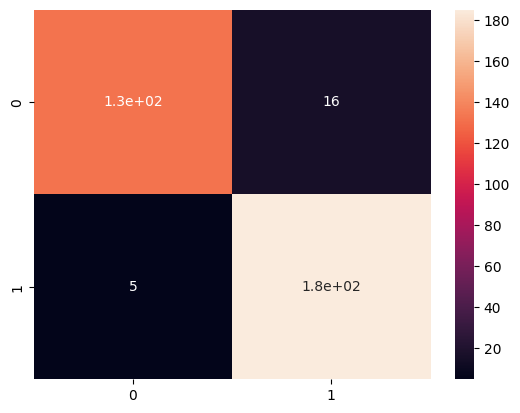

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_test = list(dataset_splits["test"]["label"])
Y_predict_test_raw = list(classifier(dataset_splits["test"]["sentence"]))

# Extract label.
def extract_label(n):
    if n["label"] == "POSITIVE":
        return 1
    return 0
Y_predict_test = list(map(extract_label, Y_predict_test_raw))

cm = confusion_matrix(Y_test, Y_predict_test)
sns.heatmap(cm, annot=True)